In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import healpy as hp
import time
import warnings
import scipy.fftpack



# functions

In [2]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #print ()
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    #print (arg.shape)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab

In [3]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

In [5]:
def comp_s1 (image, morlet_arr, jmax, gaus_arr = None ):
    
    s1_arr = np.zeros (jmax)
    i1_arr = []
    for j1 in range(jmax):
        
        #sigma1=0.8*2**j1
        #freq1=(3*np.pi)/(4.*2**j1)
        
        #mor1=morlet_2d(M, N, sigma1, freq1)
        #phi1=gabor_2d(M,N,sigma1,0)
        
        mor = morlet_arr[j1]
        mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))
        #phi1fft=np.real(np.fft.fft2(np.fft.fftshift(phi1)))
        
        img_fft = np.fft.fft2(image)
        I1_fft = img_fft * mor_fft
        I1 = np.abs (np.fft.ifft2(I1_fft))
        
        
        if gaus_arr == None:
            S1 = I1
        else:
            phi = gaus_arr[j1]
            phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
            U1_fft = np.fft.fft2(I1)
            S1_fft = U1*phi_fft
            S1 = np.real(np.fft.ifft2(S1_fft))
        
        i1_arr.append(S1)
        s1_arr[j1] = np.mean(S1)
    return s1_arr , i1_arr

In [50]:
def comp_s2 (i1_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s2_arr = np.zeros ((jmax,jmax))
    i2_arr = []
    for j1 in range(jmax):
        i2_tmp = []
        i1 = i1_arr[j1]
        i1_fft = np.fft.fft2(i1)
        
        for j2 in range (jmax):
        
            mor = morlet_arr[j2]
            mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))

            
            I2_fft = i1_fft * mor_fft
            I2 = np.abs (np.fft.ifft2(I2_fft))


            if gaus_arr == None:
                S2 = I2
            else:
                phi = gaus_arr[j2]
                phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                U2_fft = np.fft.fft2(I2)
                S2_fft = I2*phi_fft
                S2 = np.abs(np.fft.ifft2(S2_fft))

            s2_arr[j1,j2] = np.mean(S2)
            i2_tmp.append(S2)
        i2_arr.append (i2_tmp)
    return s2_arr , i2_arr

In [360]:
#loading the image
img = plt.imread ("/Users/arefe/Downloads/cat.jpg")[:,:,0]
img = img.astype('float')
liz = plt.imread ("/Users/arefe/Downloads/lizard.jpeg")
liz = liz.astype('float')

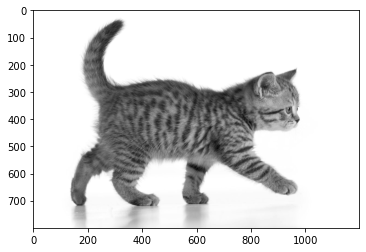

In [384]:
plt.imshow(img, cmap="gist_gray")


In [366]:
# dimensions of the picture 
# x and y sizes should be even numbers 
x_dim = np.shape (img)[0]
y_dim = np.shape (img)[1]

In [367]:
#maximum scale of the picture is chosen so that 2**jmax < min (x_dim , y_dim)
jmax = int (np.floor(np.log (min(x_dim,y_dim))/np.log(2)))

In [368]:
# making a list of morlet maps

morlet_arr = []
for j in range (jmax):
    sigma=0.8*2**j
    freq=(3*np.pi)/(4.*2**j)
    mor = morlet_2d (x_dim, y_dim, sigma, freq)
    morlet_arr.append(mor)
    
    

In [369]:
s1 , i1 = comp_s1 (img, morlet_arr, jmax)

In [370]:
s2 , i2 = comp_s2 (i1, morlet_arr, jmax)

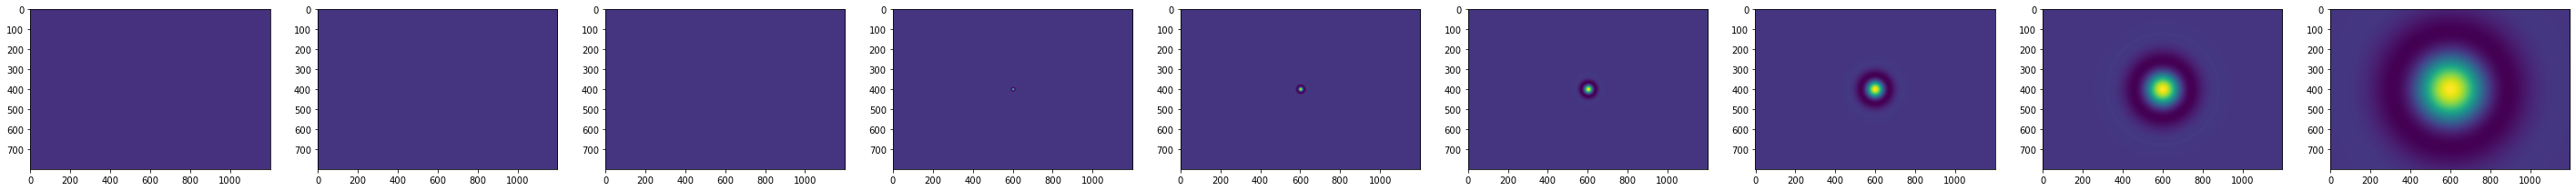

In [371]:
fig , ax = plt.subplots (1, jmax , figsize = (50,50))
for i in range (jmax):
    ax[i].imshow(np.real(morlet_arr[i]))
#plt.show()

#plt.imshow (np.real(morlet_arr[7]))

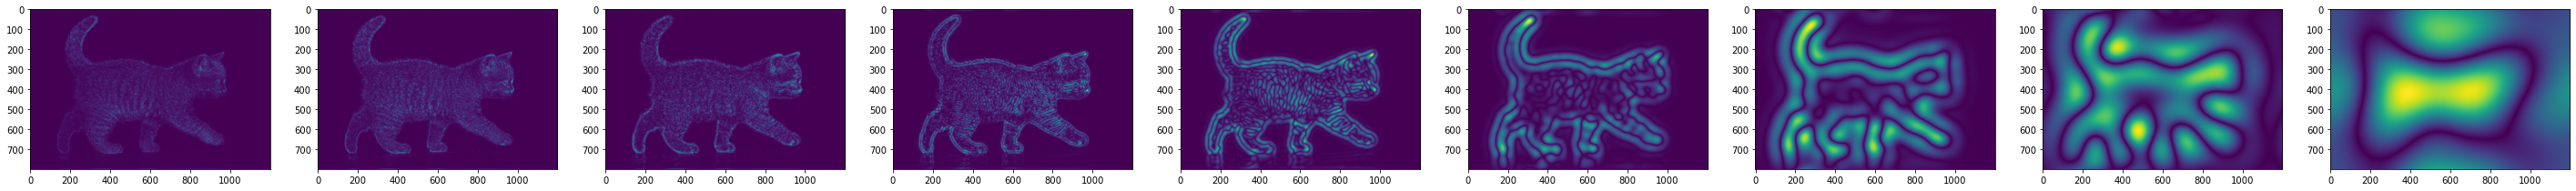

In [372]:
fig , ax = plt.subplots (1, jmax , figsize = (50,50))
for i in range (jmax):
    ax[i].imshow(i1[i])


In [373]:
# area of the image
mu0 = x_dim*y_dim

In [374]:
map_delta = np.zeros((x_dim, y_dim))
map_delta[int(x_dim/2+1),int(y_dim/2+1)] = mu0

In [375]:
s1_delta , i1_delta = comp_s1 (map_delta, morlet_arr, jmax)
s2_delta , i2_delta = comp_s2 (i1_delta, morlet_arr, jmax)

In [376]:
s1_delta

array([0.715937  , 0.55413401, 0.53359672, 0.53730664, 0.53777319,
       0.53764289, 0.53766467, 0.53762846, 0.50704471])

In [377]:
s1_normalized = s1/s1_delta
s2_normalized = s2/s2_delta

In [378]:

I0sqrt = np.sum(img**2)/mu0
I0sqrt

49498.36068020833

In [379]:
s1_normalized

array([ 0.46900428,  0.69545581,  1.01772697,  1.78384135,  2.90941147,
        4.52196394,  7.96671209,  9.83370838, 14.96509544])

In [380]:
s0_normalized = np.mean(img)
s0_normalized**2

45437.137194929564

In [381]:
s2_sum = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum += s2_normalized**2

In [382]:
s0_normalized**2+np.sum(s1_normalized**2)+np.sum(s2_normalized**2)

47452.79633003769